# Value at Risk (VaR)

[Wikipedia](https://en.wikipedia.org/wiki/Value_at_risk) definition:

> Value at Risk (VaR) is a measure of the risk of investments. It estimates how much a set of investments might lose, given normal market conditions, in a set time period such as a day. VaR is typically used by firms and regulators in the financial industry to gauge the amount of assets needed to cover possible losses.

El _valor en riesgo_ de una cartera es una medida que nos permite cuantificar las pérdidas en una inversión haciendo uso de herramientas estadísticas básicas. Para simplificar el ejercicio asumiremos que nuestra cartera esta compuesta de 1000 acciones de `AAPL` compradas a fecha de cierre del día 2 de febrero de 2015, por un valor de 106271.212€.

### Data Preparation

In [1]:
from sample_data import stock_prices
aapl = stock_prices("aapl")
msft = stock_prices("msft")
prices = aapl.Close
prices[:2]

Date
2010-01-01    30.1046
2010-01-04    30.5729
Name: Close, dtype: float64

## Cálculo básico paso por paso

### 1. Retornos diarios

In [2]:
import numpy as np

def daily_returns(closes):
    return np.log(closes / closes.shift(1))

returns = daily_returns(prices)
returns[:3]

Date
2010-01-01         NaN
2010-01-04    0.015436
2010-01-05    0.001726
Name: Close, dtype: float64

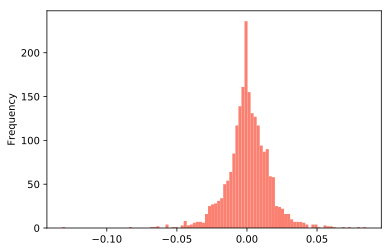

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
returns.plot.hist(bins=100, color='salmon')

La parte izquierda del gráfico muestra la frecuencia de las pérdidas (entre 8% y 6%).

Nuestro objetivo es calcular con un 95% de confianza que la mayor pérdida que podemos tener no excede de -4%. Si invertimos 100€, estamos seguros al 95% de que nuestra mayor pérdida no será mayor que 4€.

Pandas ya tiene una funcion para extraer el porcentaje de cambio frente al valor anterior.

In [4]:
prices.pct_change()[:3]

Date
2010-01-01         NaN
2010-01-04    0.015556
2010-01-05    0.001727
Name: Close, dtype: float64

### 2. Z-Score

$z = \frac{x - \mu}{\sigma}$

La función `ppf` devuelve un z-score que tiene el 95% de los datos por encima.

In [5]:
from scipy.stats import norm
z_score = norm.ppf(0.95) # loc:0 (µ), scale: 1 (σ)
z_score

1.6448536269514722

### 3. Valor del portfolio el 02/01/2015

In [6]:
shares = 1000
portfolio_value = shares * prices['2015-1-02']
portfolio_value

109330.0

### 4. Value at Risk

5% de probabilidad de perder 2949€ de nuestros 106271.212€ el dia siguiente al 2 de febrero.

${VaR} = P - P \cdot (\alpha(1-c) + 1)$, siendo $c$ el intervalo de confianza

In [7]:
alpha = z_score * returns.std()
value_at_risk = portfolio_value * alpha
value_at_risk

2814.289349489219

Podemos repetir el cálculo para todos los días

In [8]:
multiplier = (z_score * returns.std())
many_vars = (prices * 1000) * multiplier
many_vars[:3]

Date
2010-01-01    774.929618
2010-01-04    786.984239
2010-01-05    788.343376
Name: Close, dtype: float64

## Method 2: Historical data

Interpretations:
- 5% chance of losing at least 10000€
- 95% of probability of losing no more than 10000€ the following day

In [9]:
def estimate_historical(returns, probability, portfolio_size):
    if (probability > 0.5):
        probability = 1 - probability
    return -(returns.quantile(probability) * portfolio_size)
    
estimate_historical(returns[1:], 0.05, portfolio_value)

2719.172243700173

In [10]:
def estimate_historical_normal_distribution(returns, probability, portfolio_size):
    if (probability > 0.5):
        probability = 1 - probability
    expected_return = returns.mean()
    std_dev = returns.std()
    return -(norm.ppf(probability, expected_return, std_dev) * portfolio_size)

estimate_historical_normal_distribution(returns[1:], 0.05, portfolio_value)

2723.31190045828

## Method 3: Variance-Covariance Method
 
Given a portfolio of $P$ size with a confidence level of $c$, and considering daily returns. This method does not use actual returns, it assumes our returns data follows a normal distribution.
 
Daily VaR for a single asset is $P - (P \cdot (\alpha(1-c) + 1))$
 
Where α is the inverse of the cumulative distribution function of a normal distribution with mean μ and standard deviation σ.

In [11]:
def var_covar(P, c, mu, sigma):
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

var_covar(portfolio_value, 0.95, returns.mean(), returns.std())

2723.311900458284